# Load libraries, functions an data

## Libraries



In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import pickle

from sklearn.model_selection import train_test_split
from  sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support

import pickle

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from features import *


## Functions

In [2]:
def lag_columns(df, not_lag, lag_list):

    for col in df.drop(columns=not_lag).columns:
        for lag in lag_list:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    lag_columns_to_keep = [col for col in df.columns if any(f"_lag{lag}" in col for lag in lag_list) or col in not_lag]

    df = df[lag_columns_to_keep]

    return df

def line_chart(data, variables_list, title, width=1000, height=500):
    fig = go.Figure()

    for var in variables_list:
        fig.add_trace(go.Scatter(x=data.index, y=data[var], mode='lines', name=var))

    fig.update_layout(
        title=title,
        xaxis_title='Fecha',
        yaxis_title='Real',
        template='plotly_dark',
        height=height,
        width=width
    )

    fig.show()

def max_drawdown(columns):
    max_profit = columns.expanding().max()
    drawdown = (max_profit - columns)
    max_drawdown = drawdown.max()
    return max_drawdown

def split(date1,date2,df):
    dataframe = df.copy()
    objective = dataframe.columns[:1].values[0]
    vol_name = dataframe.columns[1]
    volatility = dataframe[vol_name]
    dataframe = dataframe.drop(columns=vol_name)
    X = dataframe.iloc[:,1:]
    y = dataframe.iloc[:,:1]


    X_train = X.loc[X.index<=date1]
    y_train = y.loc[y.index<=date1]

    X_val = X.loc[(X.index>date1) & (X.index<=date2)]
    y_val = y.loc[(y.index>date1) & (y.index<=date2)]

    X_test = X.loc[X.index>date2]
    y_test = y.loc[y.index>date2]

    return X_train, y_train, X_val, y_val, X_test, y_test, objective, volatility, vol_name

def split_trend(date1,df):
    dataframe = df.copy()
    objective = dataframe.columns[:1].values[0]
    vol_name = dataframe.columns[1]
    volatility = dataframe[vol_name]
    dataframe = dataframe.drop(columns=vol_name)
    X = dataframe.iloc[:,1:]
    y = dataframe.iloc[:,:1]


    X_train = X.loc[X.index<=date1]
    y_train = y.loc[y.index<=date1]

    X_test = X.loc[X.index>date1]
    y_test = y.loc[y.index>date1]

    return X_train, y_train, X_test, y_test, objective, volatility, vol_name

def split_diff(date1,df):

    dataframe = df.copy()
    objective = dataframe.columns[:1].values[0]

    X = dataframe.iloc[:,1:]
    y = dataframe.iloc[:,:1]

    X_train = X.loc[X.index<=date1]
    y_train = y.loc[y.index<=date1]

    X_test = X.loc[X.index>date1]
    y_test = y.loc[y.index>date1]

    return X_train, y_train, X_test, y_test, objective


def subplot(df):
    plt.rcParams['font.family'] = 'serif'

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharex=True, sharey=True)

    plt.subplots_adjust(hspace=0.15, wspace=0.15)

    for ax, ((model, trend), df) in zip(axes.flatten(), df.items()):
        ax.plot(df['Date'], df['profit'])#, label=f'{model} - {trend}')

        ax.set_xlabel('Date')
        ax.set_ylabel('Profit')
        ax.set_title(f'Profit of {model} - {trend}')
        ax.legend()

        ax.grid(True)

    fig.autofmt_xdate()
    
    plt.suptitle('Profit (in %) of models for each independent variable over time', y=0.93, fontsize=20)
    #plt.savefig('./subplot_rendimientos2.png', dpi=800)

    plt.show()

def subplot_vol(df):
    plt.rcParams['font.family'] = 'serif'

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharex=True, sharey=True)

    plt.subplots_adjust(hspace=0.15, wspace=0.15)

    for ax, ((model, trend), df) in zip(axes.flatten(), df.items()):
        ax.plot(df['Date'], df.iloc[:,1:2], label='Real volatility')
        ax.plot(df['Date'], df.iloc[:,-1:], label='Predictions')

        ax.set_xlabel('Date')
        ax.set_ylabel('Real vs Preds')
        ax.set_title(f'Preds of {model} - {trend}')
        ax.legend()

        ax.grid(True)

    fig.autofmt_xdate()
    
    plt.suptitle('Predicted Volatility vs Real values (in %) of models for each independent variable over time', y=0.93, fontsize=20)
    #plt.savefig('./subplot_rendimientos2.png', dpi=800)
    plt.show()

def market_return(df):
    df["Market_return"] = 0.0
    df.at[df.index[0], "Market_return"] = 0.0

    for i in range(1, len(df)):
        initial_price = df['Close'].iloc[0]  
        final_price = df['Close'].iloc[i]   
        rendimiento_total = ((final_price / initial_price) - 1) * 100
        df.at[df.index[i], 'Market_return'] = rendimiento_total

    return df

## Data

In [3]:
data = pd.read_csv("./Datos ecopetrol/DATOS_PREDICTIVOS_EC.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
data = data.set_index("Date")
data["close1"] = data["Close"].shift(-1)
column_to_insert = data['close1']
data.drop(columns=['close1'], inplace=True)
data.insert(0, 'close1', column_to_insert)

market_return_data = data[["Close","diff"]]

data.iloc[:,:17]

data = data.drop(columns=["Close", "Open","diff","trend","open1"])

topic_columns = [col for col in data.columns if 'Topic' in col]
data[topic_columns] = data[topic_columns].apply(pd.to_numeric, errors='coerce').astype('Int64')
#
#var_cat = data.select_dtypes(include=['object', 'category']).columns.tolist()
#data = pd.get_dummies(data, columns=var_cat)

# Without topics
#data = data.loc[:, ~data.columns.str.contains('Topic')]

# Without sentiment
columnas_sentimiento = ['negative_vader', 'neutral_vader', 'positive_vader',
                        'negative', 'neutral', 'positive',
                        'title_vader_sentiment', 'headline_vader_sentiment',
                        'finbert_numeric', 'average_title_vader_10periods',
                        'average_headline_vader_10periods',
                        'average_finbert_10periods']

# Filtrar columnas que no están relacionadas con el sentimiento
#data = data.drop(columns=columnas_sentimiento)

data = data.dropna()

data.rename(columns={"diff1": "return1", "diff2": "return2", "diff3": "return3", "diff4": "return4"}, inplace=True)

# Objectives
trend1 = data.drop(columns=["trend2","trend3","trend4","return2","return3","return4","close1","close2","close3","close4"])
trend2 = data.drop(columns=["trend1","trend3","trend4","return1","return3","return4","close1","close2","close3","close4"])
trend3 = data.drop(columns=["trend1","trend2","trend4","return1","return2","return4","close1","close2","close3","close4"])
trend4 = data.drop(columns=["trend1","trend2","trend3","return1","return2","return3","close1","close2","close3","close4"])
return1 = data.drop(columns=["trend1","trend2","trend3","trend4","return2","return3","return4","close1","close2","close3","close4"])
return2 = data.drop(columns=["trend1","trend2","trend3","trend4","return1","return3","return4","close1","close2","close3","close4"])
return3 = data.drop(columns=["trend1","trend2","trend3","trend4","return1","return2","return4","close1","close2","close3","close4"])
return4 = data.drop(columns=["trend1","trend2","trend3","trend4","return1","return2","return3","close1","close2","close3","close4"])

# Feature selection 

trend1 = trend1[["trend1","return1"]]
trend2 = trend2[["trend2","return2"]]
trend3 = trend3[["trend3","return3"]]
trend4 = trend4[["trend4","return4"]]

trend1[features_trend1] = data[features_trend1]
trend2[features_trend2] = data[features_trend2]
trend3[features_trend3] = data[features_trend3]
trend4[features_trend4] = data[features_trend4]

return1 = return1[["return1"]]
return2 = return2[["return2"]]
return3 = return3[["return3"]]
return4 = return4[["return4"]]

return1[features_diff1] = data[features_diff1]
return2[features_diff2] = data[features_diff2]
return3[features_diff3] = data[features_diff3]
return4[features_diff4] = data[features_diff4]


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 574 entries, 2012-09-02 to 2023-11-26
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   close1                            574 non-null    float64
 1   close2                            574 non-null    float64
 2   close3                            574 non-null    float64
 3   close4                            574 non-null    float64
 4   trend1                            574 non-null    int64  
 5   trend2                            574 non-null    int64  
 6   trend3                            574 non-null    int64  
 7   trend4                            574 non-null    int64  
 8   return1                           574 non-null    float64
 9   return2                           574 non-null    float64
 10  return3                           574 non-null    float64
 11  return4                           574 non-null    fl

# Trends

## Classification models

In [4]:
classifiers = [
    RandomForestClassifier(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
]

### Test for the 30% rest of data

In [9]:
date1 = "2020-07-12"

trend_list = [trend1, trend2, trend3, trend4]

accuracy = []
model = []
objectives = []
precisions_0 = []
precisions_1 = []
recalls_0 = []
recalls_1 = []
supports_0 = []
supports_1 = []

profits = []

longs_results = {}

for df in trend_list:
    X_train, y_train, X_test, y_test, objective, volatility, vol_name = split_trend(date1, df)
    for clf in classifiers:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # General accuracy
        accuracy.append(accuracy_score(y_test, y_pred))

        # Many metrics
        precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
        precision_0 = precision[0]
        precision_1 = precision[1]
        recall_0 = recall[0]
        recall_1 = recall[1]
        support_0 = support[0]
        support_1 = support[1]

        model.append(clf.__class__.__name__)
        objectives.append(vol_name)

        precisions_0.append(precision_0)
        precisions_1.append(precision_1)
        recalls_0.append(recall_0)
        recalls_1.append(recall_1)
        supports_0.append(support_0)
        supports_1.append(support_1)

        # Strategy
        str_val = y_test.copy()
        str_val["pred"] = y_pred.copy()
        str_val = str_val.reset_index()
        strategy_results = pd.merge(str_val, volatility, on="Date")
        longs = strategy_results.loc[strategy_results["pred"]==1]

        profit = 0
        if vol_name == "return1":
            longs["profit"] = longs[vol_name].cumsum()
            profit = longs[vol_name].sum()
        if vol_name == "return2":
            longs["profit"] = (longs[vol_name].cumsum())/2
            profit = longs[vol_name].sum()/2
        if vol_name == "return3":
            longs["profit"] = (longs[vol_name].cumsum())/3
            profit = longs[vol_name].sum()/3
        if vol_name == "return4":
            longs["profit"] = (longs[vol_name].cumsum())/4
            profit = longs[vol_name].sum()/4

        profit = round(profit,2)
        profits.append(profit)
        longs_results[clf.__class__.__name__, objective] = longs

        # Save models
        filename = f"./Modelos/Trend/{clf.__class__.__name__}_{objective}_{profit}.pkl"
        with open(filename, 'wb') as file:
            pickle.dump(clf, file)


results_test = pd.DataFrame({"Model": model,"Objective": objectives,"Accuracy": accuracy,
                        "Precision_0": precisions_0,"Precision_1": precisions_1,
                        "Recall_0": recalls_0,"Recall_1": recalls_1,
                        "Support_0": supports_0,"Support_1": supports_1,"Profit":profits})
results_test = round(results_test,2)

In [40]:
#file_path = "./Modelos/Trend/longs_results.pkl"
#with open(file_path, 'wb') as file:
#    pickle.dump(longs_results, file)

file_path = "./Modelos/Trend/longs_results.pkl"

with open(file_path, 'rb') as file:
    longs_results = pickle.load(file)

#results_df = results_test.copy()
#df = results_test.copy()
#df["Objective"] = df["Objective"].replace({"diff1":"trend1","diff2":"trend2","diff3":"trend3","diff4":"trend4"})
#df.to_excel("./Modelos/Trend/trend_results.xlsx", index=False)

results_df = pd.read_excel("./Modelos/Trend/trend_results.xlsx")

results_df

,Model,Objective,Accuracy,Precision_0,Precision_1,Recall_0,Recall_1,Support_0,Support_1,Profit
0,RandomForestClassifier,trend1,0.44,0.44,0.43,0.49,0.38,87,87,-57.98
1,KNeighborsClassifier,trend1,0.45,0.45,0.44,0.49,0.40,87,87,-57.35
2,GradientBoostingClassifier,trend1,0.48,0.48,0.47,0.64,0.31,87,87,-34.83
3,XGBClassifier,trend1,0.46,0.46,0.45,0.53,0.39,87,87,-29.44
4,RandomForestClassifier,trend2,0.39,0.37,0.39,0.27,0.51,90,84,-83.63
5,KNeighborsClassifier,trend2,0.52,0.54,0.50,0.46,0.58,90,84,3.83
6,GradientBoostingClassifier,trend2,0.49,0.52,0.48,0.34,0.65,90,84,28.99
7,XGBClassifier,trend2,0.44,0.44,0.44,0.30,0.60,90,84,-40.72
8,RandomForestClassifier,trend3,0.49,0.44,0.53,0.49,0.48,79,95,-1.82
9,KNeighborsClassifier,trend3,0.52,0.48,0.57,0.49,0.55,79,95,26.55


In [ ]:
subplot(longs_results)

# Volatility

In [42]:
regressors = [
    RandomForestRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor()
]

In [75]:
date1 = "2020-07-12"

return_list = [return1, return2, return3, return4]

abs_errors = []
objectives = []

models = []

profits = []

longs_results = {}
models_results = {}

for df in return_list:
    X_train, y_train, X_test, y_test, objective = split_diff(date1, df)
    for reg in regressors:
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        # General errors

        abs_error = mean_absolute_error(y_test, y_pred)
        abs_errors.append(abs_error)

        models.append(reg.__class__.__name__)
        objectives.append(objective)

        # Strategy
        strategy_results = y_test.copy()
        strategy_results["pred"] = y_pred.copy()
        models_results[reg.__class__.__name__,objective] = strategy_results.copy().reset_index()
 
        longs = strategy_results.loc[strategy_results["pred"]>1]

        profit = 0
        if objective == "return1":
            longs["profit"] = longs[objective].cumsum()
            profit = longs[objective].sum()
        if objective == "return2":
            longs["profit"] = (longs[objective].cumsum())/2
            profit = longs[objective].sum()/2
        if objective == "return3":
            longs["profit"] = (longs[objective].cumsum())/3
            profit = longs[objective].sum()/3
        if objective == "return4":
            longs["profit"] = (longs[objective].cumsum())/4
            profit = longs[objective].sum()/4

        profit = round(profit,2)
        profits.append(profit)
        longs_results[reg.__class__.__name__, objective] = longs.reset_index()


        # Save models
        filename = f"./Modelos/Volatility/{reg.__class__.__name__}_{objective}_{profit}.pkl"
        with open(filename, 'wb') as file:
            pickle.dump(reg, file)


results_test = pd.DataFrame({"Model":models,"Objective":objectives,"Absolute error":abs_errors,"Profit":profits})
results_test = round(results_test,2)

In [78]:
#file_path = "./Modelos/Volatility/longs_results.pkl"
#with open(file_path, 'wb') as file:
#    pickle.dump(longs_results, file)

file_path = "./Modelos/Volatility/longs_results.pkl"
with open(file_path, 'rb') as file:
    longs_results = pickle.load(file)

#results_df = results_test.copy()
#df = results_test.copy()
#df["Objective"] = df["Objective"].replace({"diff1":"return1","diff2":"return2","diff3":"return3","diff4":"return4"})
#df.to_excel("./Modelos/Volatility/return_results.xlsx", index=False)

results_df = pd.read_excel("./Modelos/Volatility/return_results.xlsx")

results_df

,Model,Objective,Absolute error,Profit
0,RandomForestRegressor,return1,4.65,-19.36
1,KNeighborsRegressor,return1,4.42,-6.55
2,GradientBoostingRegressor,return1,4.48,-3.48
3,XGBRegressor,return1,4.90,11.72
4,RandomForestRegressor,return2,7.25,-23.56
5,KNeighborsRegressor,return2,7.29,-16.84
6,GradientBoostingRegressor,return2,7.27,-31.87
7,XGBRegressor,return2,8.47,-17.19
8,RandomForestRegressor,return3,8.74,3.97
9,KNeighborsRegressor,return3,8.99,1.67


In [76]:
# Best models
results_test.sort_values(by="Profit",ascending=False)

,Model,Objective,Absolute error,Profit
12,RandomForestRegressor,return4,9.33,33.75
11,XGBRegressor,return3,9.26,25.10
10,GradientBoostingRegressor,return3,9.16,22.62
15,XGBRegressor,return4,11.63,14.36
13,KNeighborsRegressor,return4,9.92,14.02
3,XGBRegressor,return1,4.90,11.72
14,GradientBoostingRegressor,return4,11.91,11.23
8,RandomForestRegressor,return3,8.74,3.97
9,KNeighborsRegressor,return3,8.99,1.67
2,GradientBoostingRegressor,return1,4.48,-3.48


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

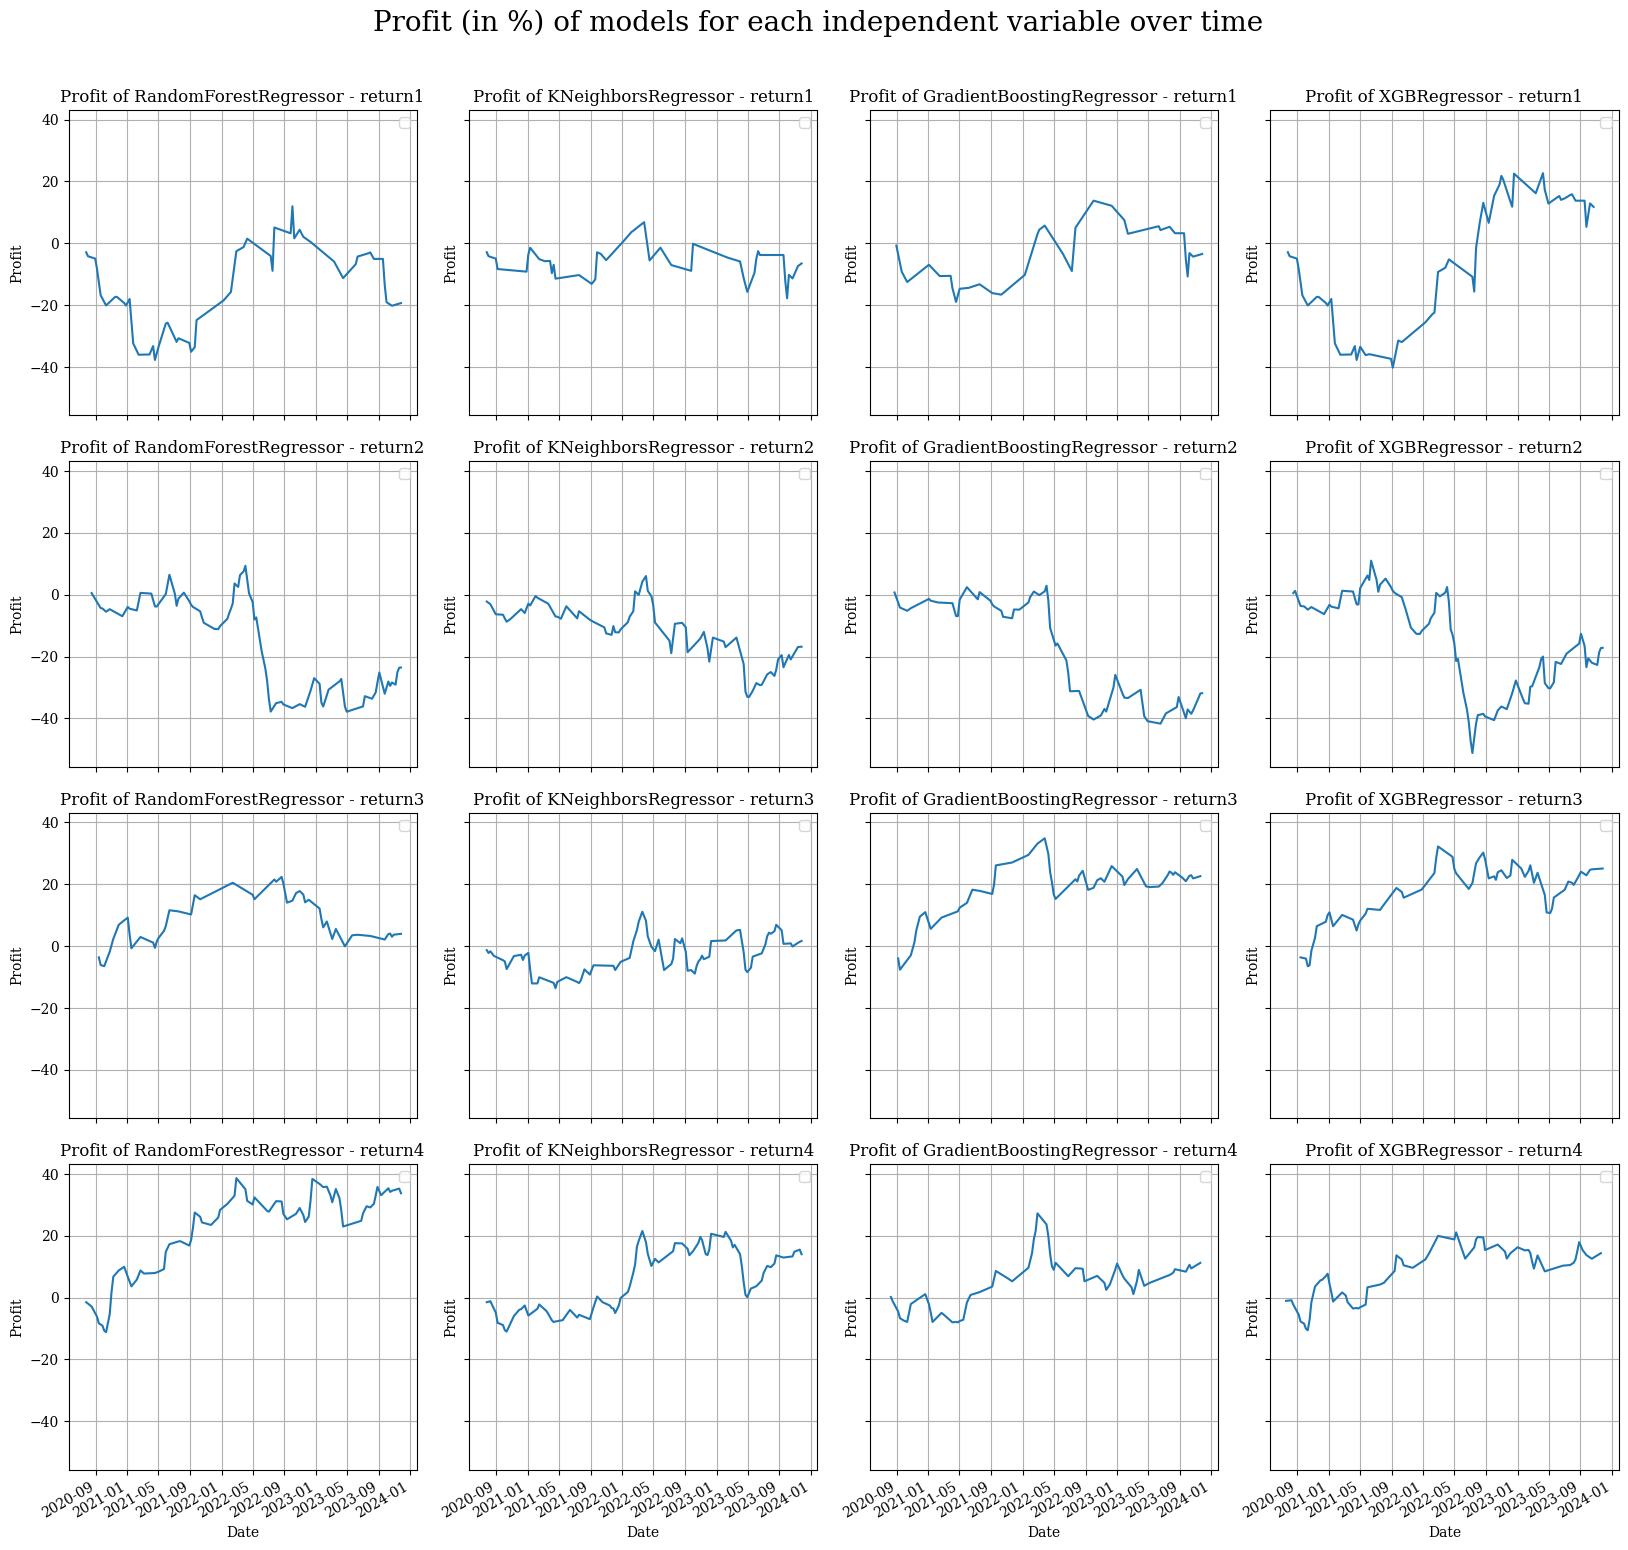

In [79]:
subplot(longs_results)

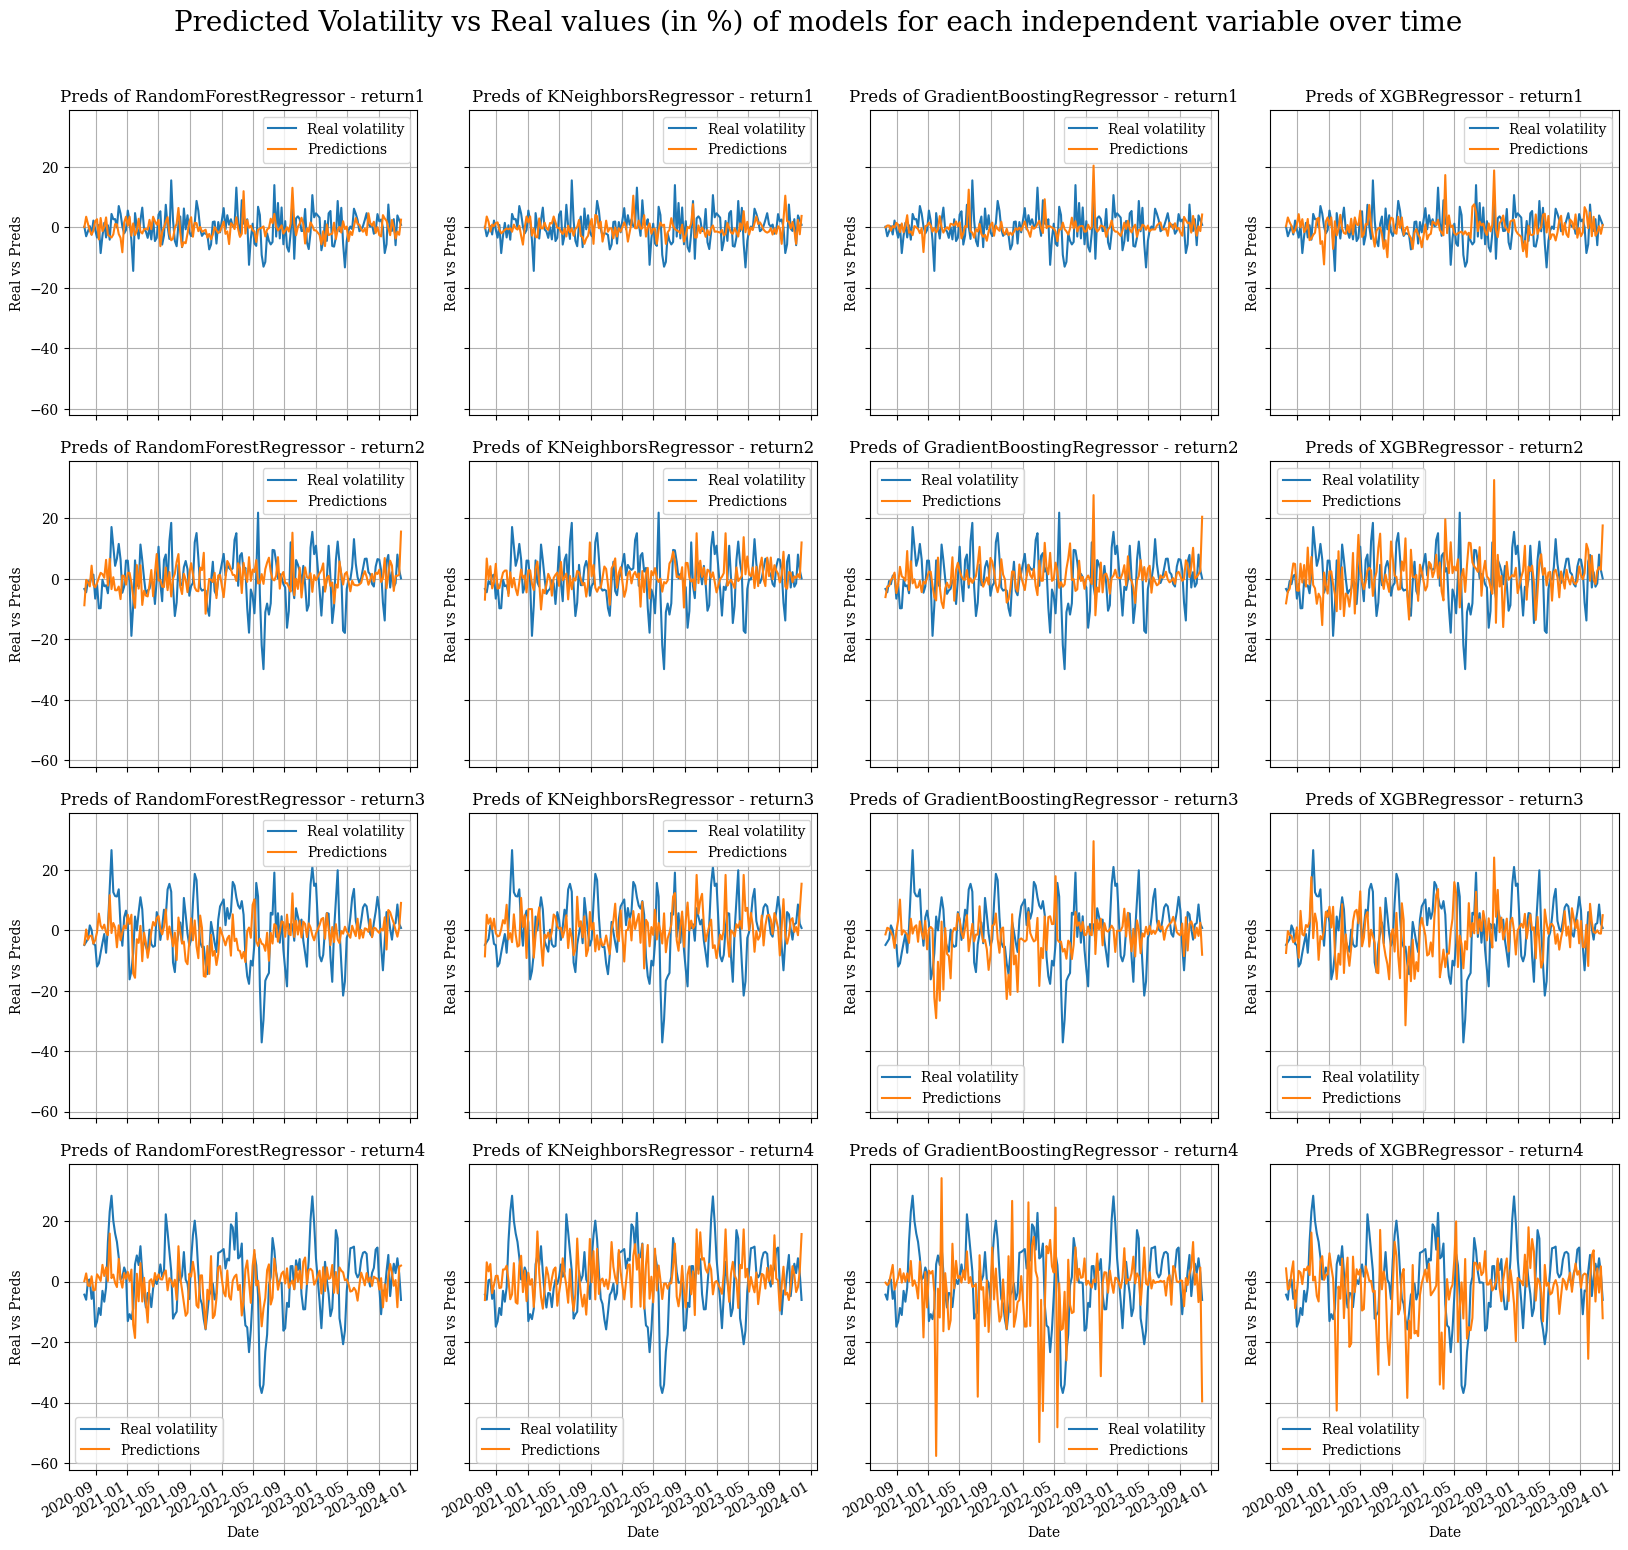

In [80]:
subplot_vol(models_results)

In [14]:
#longs_results["GradientBoostingRegressor","diff4"].to_excel("./longs_results_comprobación.xlsx")

# Return from market in the same period

In [81]:
date1 = "2020-07-12"

market_return_data = market_return_data.loc[market_return_data.index>date1]
market_return_data = market_return(market_return_data)

In [ ]:
def line_chart(data, variables_list, title, width=1000, height=500):
    fig = go.Figure()

    for var in variables_list:
        fig.add_trace(go.Scatter(x=data.index, y=data[var], mode='lines', name=var))

    fig.update_layout(
        title=title,
        xaxis_title='Fecha',
        yaxis_title='Real',
        template='plotly_dark',
        height=height,
        width=width
    )

    fig.show()

In [85]:
def line_chart(data, variables_list, title, width=10, height=5):
    plt.figure(figsize=(width, height))
    
    for var in variables_list:
        plt.plot(data.index, data[var], label=var)
    
    plt.title(title)
    plt.xlabel('Fecha')
    plt.ylabel('Real')
    plt.grid(True)  # Activar regillas
    plt.legend()
    plt.tight_layout()
    plt.show()

In [89]:
market_return_data

,Close,diff,Market_return
Date,,,
2020-07-19,12.08,5.318218,0.000000
2020-07-26,12.07,0.249167,-0.082783
2020-08-02,11.64,-2.919095,-3.642381
2020-08-09,11.46,-1.291986,-5.132449
2020-08-16,11.53,0.435542,-4.552982
...,...,...,...
2023-11-05,12.36,2.743142,2.317879
2023-11-12,11.72,-5.863450,-2.980130
2023-11-19,12.27,3.983053,1.572852


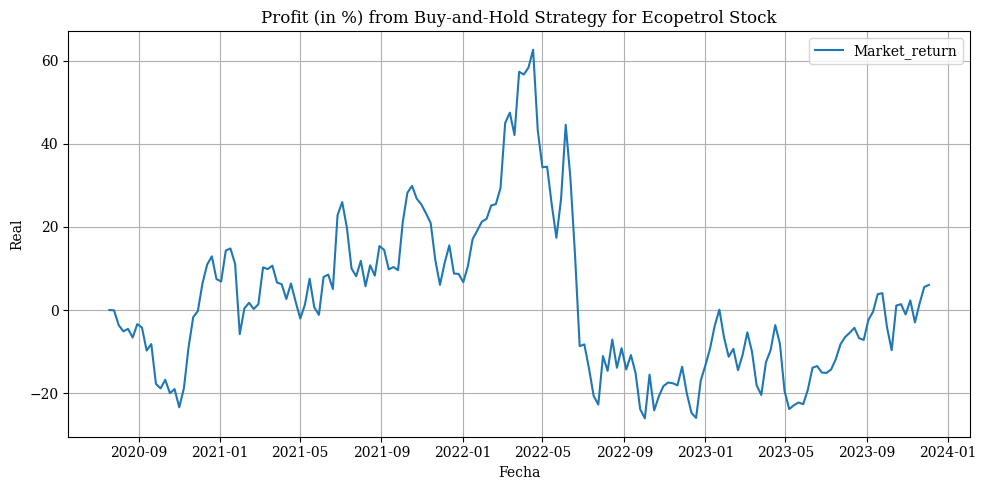

In [88]:
line_chart(market_return_data, ["Market_return"], "Profit (in %) from Buy-and-Hold Strategy for Ecopetrol Stock", 10,5)